In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

import matplotlib.pyplot as plt

# Introduction

The aim of this notebook is to provide an example aplication of a machine learning (ML) model to predict the dailly grose primary product (GPP, CO2 uptake) at the Howard Springs flux tower site.

# Initial data setup

This first section of the notebook is used to create a data set that can be used for machine learning. The data set will contain the dailly GPP along with a set of measurments of the environment (e.g. daily mean temperature). The measurments are the values that will be given to the ML model to predict the dailly GPP.

## Load the data

The code bellow is taken from Martin's notebook "Opening flux and met data for HowardSprings". It is simply used to load the data into the notebook and format it prior to converting to daily values.

In [2]:
# File information
data_folder = "/Users/jb14389/Desktop/Flux_data/OZFlux2.0/OzFlux/"

site_name = "HowardSprings"

site_flux_file = site_name + "OzFlux2.0_flux.nc"
site_met_file  = site_name + "OzFlux2.0_met.nc"

# Load in the flux and met data for HowardSprings
ds_flux = xr.open_dataset(data_folder + site_flux_file, decode_times=False)
ds_met = xr.open_dataset(data_folder + site_met_file, decode_times=False)

Create a time axis for the data.

In [3]:
time_jump = int(ds_flux.time[1].values) - int(ds_flux.time[0].values)

if time_jump == 3600:
    freq = "1h"
elif time_jump == 1800:
    freq = "0.5h"
elif time_jump == 10800:
    freq = "3h"
else:
    raise("Time problem")

units, reference_date = ds_flux.time.attrs['units'].split('since')
start = reference_date.strip().split(" ")[0].replace("-","/")

ds_flux['time'] = pd.date_range(start=start, periods=len(ds_flux.GPP), freq=freq)
ds_met['time'] = pd.date_range(start=start, periods=len(ds_flux.GPP), freq=freq)

Drop unused dimentions

In [4]:
# drop xyz dims
ds_flux = ds_flux.squeeze(dim = ["x","y"], drop = True)
ds_met = ds_met.squeeze(dim = ["x","y","z"], drop = True)

Calculate vapour pressure deficit (VPD) from specific humidity, air temperatuer and air pressure.

In [5]:
def qair_to_vpd(qair, tair, press):

    """
    Qair : float
        specific humidity [kg kg-1]
    tair : float
        air temperature [deg K]
    press : float
        air pressure [Pa]
    """

    PA_TO_KPA = 0.001
    HPA_TO_PA = 100.0

    tc = tair - 273.15

    # saturation vapor pressure (Pa)
    es = HPA_TO_PA * 6.112 * np.exp((17.67 * tc) / (243.5 + tc))

    # vapor pressure
    ea = (qair * press) / (0.622 + (1.0 - 0.622) * qair)

    vpd = (es - ea) * PA_TO_KPA

    vpd = np.where(vpd < 0.05, 0.05, vpd)

    return vpd

ds_met['VPD'] = (['time'],qair_to_vpd(ds_met.Qair, ds_met.Tair, ds_met.PSurf))

## Converting to daily values

Now that both the met and flux data sets have been loaded and formatted the next step is to convert them from measurements of every half hour to a single data set of daily values.

### Daily GPP

First the code bellow calculates the total GPP for each day in kg m$^{-2}$ day$^{-1}$.

The current GPP values in ds_flux are in umol m$^{-2}$ s$^{-1}$, so it is necessary to first convert the units to kg m$^{-2}$ half hour$^{-1}$ before summing each day to get the daily GPP (kg m$^{-2}$ day$^{-1}$

In [6]:
molCO2_to_kgCO2 = 0.044 # kg(CO2) mol(CO2)^-1

# umol -> kg
ds_flux['GPP'] = ds_flux.GPP * 10**(-6) * molCO2_to_kgCO2

# kg -> g
ds_flux['GPP'] = ds_flux.GPP * 10**(3)

# s-1 -> time jump-1
ds_flux['GPP'] = ds_flux.GPP * time_jump

# Update the units for GPP
ds_flux['GPP'] = ds_flux.GPP.assign_attrs(units="g m-2 half hour-1",
                                          long_name = "Gross primary poductivity of CO2")

Sum the GPP over each day to get a total.

In [7]:
# Summ over each day
ds_daily = ds_flux.GPP.resample(time="1D").sum().to_dataset()

# Update the units for GPP
ds_daily = ds_daily.assign_attrs(units="kg m-2 day-1",
                                 long_name = "Gross primary poductivity of CO2")

ds_daily

<xarray.Dataset> Size: 57kB
Dimensions:  (time: 4748)
Coordinates:
  * time     (time) datetime64[ns] 38kB 2002-01-01 2002-01-02 ... 2014-12-31
Data variables:
    GPP      (time) float32 19kB 22.67 22.97 18.14 29.82 ... 33.13 22.13 27.44
Attributes:
    units:      kg m-2 day-1
    long_name:  Gross primary poductivity of CO2

### Daily means
Calculate the daily mean values for a set of measured conditions.

In [8]:
met_colls = ['Tair', 'Rainf', 'PSurf', 'LWdown', 'CO2air', 'VPD']

for col in met_colls:
    ds_daily[col + "_daily_mean"] = ds_met[col].resample(time="1D").mean()

ds_daily

<xarray.Dataset> Size: 171kB
Dimensions:            (time: 4748)
Coordinates:
  * time               (time) datetime64[ns] 38kB 2002-01-01 ... 2014-12-31
Data variables:
    GPP                (time) float32 19kB 22.67 22.97 18.14 ... 22.13 27.44
    Tair_daily_mean    (time) float32 19kB 300.8 301.8 299.2 ... 298.1 297.7
    Rainf_daily_mean   (time) float32 19kB 6.941e-06 2.314e-06 ... 0.0008426
    PSurf_daily_mean   (time) float32 19kB 1.003e+05 1.004e+05 ... 1.001e+05
    LWdown_daily_mean  (time) float32 19kB 405.7 405.9 404.0 ... 400.0 401.6
    CO2air_daily_mean  (time) float32 19kB 369.4 363.1 362.8 ... 380.7 378.3
    VPD_daily_mean     (time) float32 19kB 0.5196 0.6971 ... 0.5475 0.4262
Attributes:
    units:      kg m-2 day-1
    long_name:  Gross primary poductivity of CO2

It is worth considering what other values could be of use to the ML model when predicting the daily GPP. Are there other measured properties or summary statistics for each day (e.g max value) that could be used? Are the values chosen here beneficial or should they not be given to the model?

# ML aplication

The aim of this section is to apply a machine learning model to estimate the daily GPP from the set of measured environmental properties within the ds_daily data set.

## Data exploration

Prior to applying a ML model to solve any problem the first step is to explore and understand the dataset being used. This step is important as our understanding of the data set and the physical processes involved informs future desicions when applying and analyssing a ML model. Such decissions include, the choice of ML model, which data to provide to the model and how to asses if the predictions of the model are reliable. An exploration of the data set may also show a much simpler non-ML solution to the problem you are trying to solve.

There are many ways to explore and understand a data set, here we simply plot the distributions of different measured environmental properties.

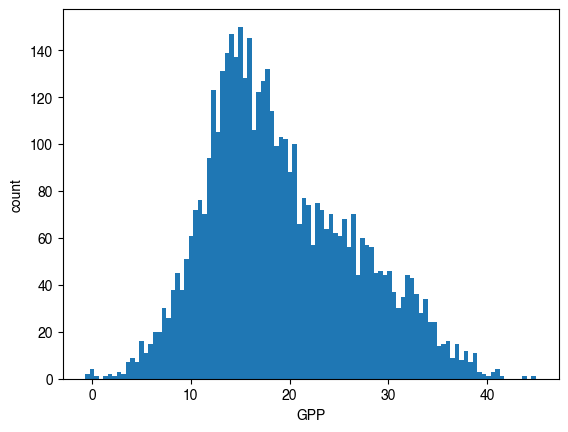

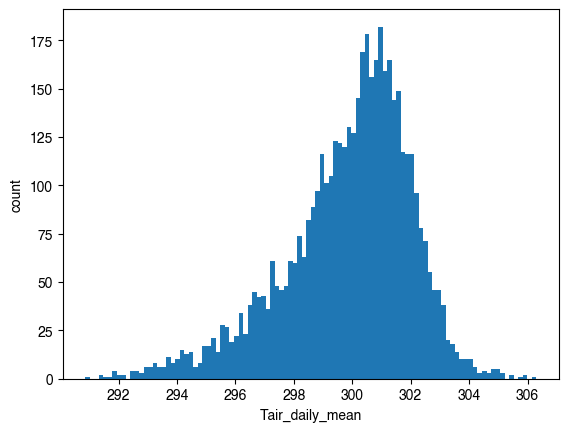

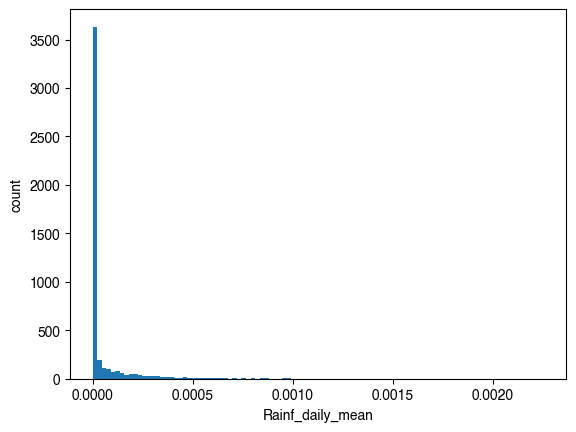

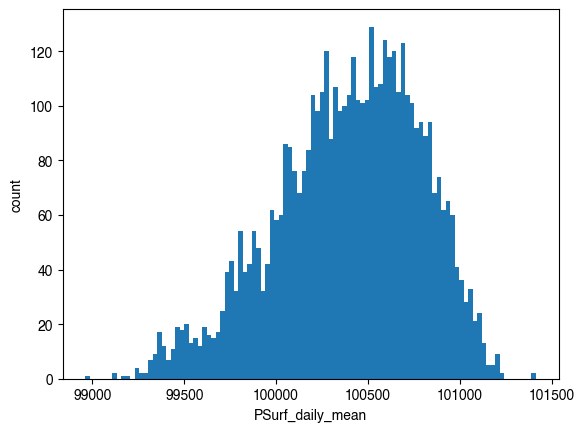

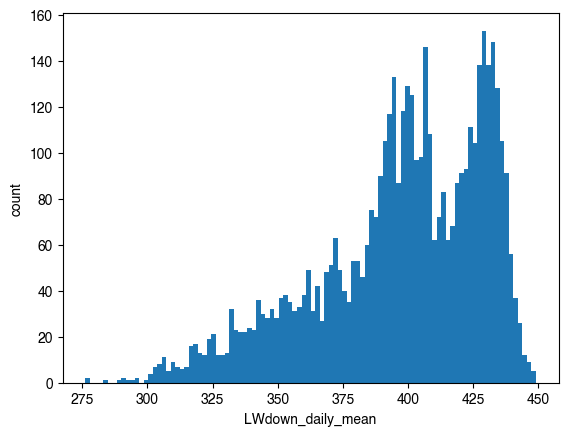

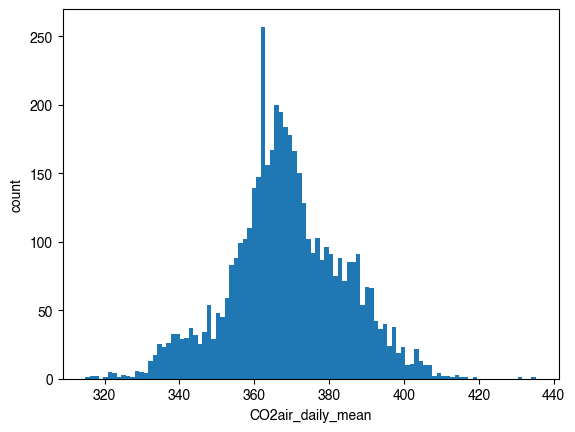

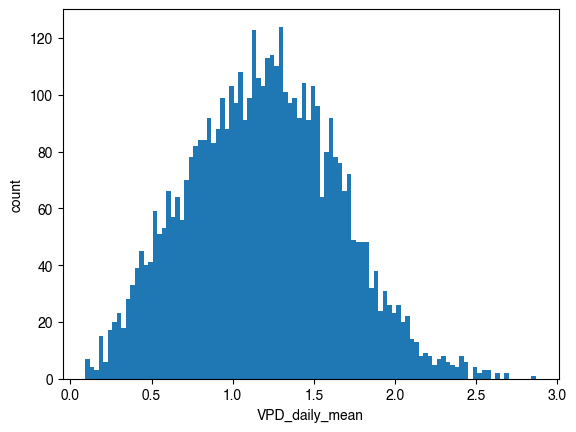

In [9]:
# Get list of coluns
cols = list(ds_daily.keys())
#units = ["kg m-2 day-1","",""]

for col in cols:
    plt.hist(ds_daily[col], bins = 100)
    plt.ylabel("count")
    plt.xlabel(col)
    plt.show()

## Clean the data

When exploring the data it is likly that we will find individul entries that for whatever reason will cause probelms when used for ML. Such entries include, missing and incorect values that a ML model can not process or non-physical and outlier values which can imact the accuracy of the ML model. Note that what consitutes an outlier or non-physical value depends on the data set and system bein modeld respectivly.

For the ds_daily data set the code below removes all days with one or more missing entry.

In [10]:
# drops a time row if any entries are nan.
ds_daily = ds_daily.dropna(dim="time", how="any")
ds_daily

<xarray.Dataset> Size: 171kB
Dimensions:            (time: 4748)
Coordinates:
  * time               (time) datetime64[ns] 38kB 2002-01-01 ... 2014-12-31
Data variables:
    GPP                (time) float32 19kB 22.67 22.97 18.14 ... 22.13 27.44
    Tair_daily_mean    (time) float32 19kB 300.8 301.8 299.2 ... 298.1 297.7
    Rainf_daily_mean   (time) float32 19kB 6.941e-06 2.314e-06 ... 0.0008426
    PSurf_daily_mean   (time) float32 19kB 1.003e+05 1.004e+05 ... 1.001e+05
    LWdown_daily_mean  (time) float32 19kB 405.7 405.9 404.0 ... 400.0 401.6
    CO2air_daily_mean  (time) float32 19kB 369.4 363.1 362.8 ... 380.7 378.3
    VPD_daily_mean     (time) float32 19kB 0.5196 0.6971 ... 0.5475 0.4262
Attributes:
    units:      kg m-2 day-1
    long_name:  Gross primary poductivity of CO2

The code bellow is used to identify and drop days contaning an outlier value, where an outlier is a value more than 5 standard deviations from the mean of that column. Note this includes GPP, how might this affect the results?

In [11]:
# Number of standard deviations a value needs to exceded to be considerd an outlier.
outlier_std = 5.

# Get list of coluns
cols = list(ds_daily.keys())

# calculate the mean and standard deviatio for each column.
col_means = ds_daily.mean().to_pandas().to_numpy()
col_std = ds_daily.std().to_pandas().to_numpy()

print("Column : Mean : STD")
for i in range(len(cols)):
    print(cols[i], " : ", col_means[i], " : ", col_std[i])

# -- calculate the number of standard deviations from the mean for each value --
# Convert the array to numpy
std_from_mean = ds_daily[cols].to_pandas().to_numpy()

# convert to std from mean
std_from_mean -= col_means
std_from_mean /= col_std
std_from_mean = np.abs(std_from_mean)

# Identify entires where the std from the mean is larger than the outlier threshold
is_outlier = std_from_mean > outlier_std
print("is_outlier array shape: ", is_outlier.shape)

# Identify entries containing an outlier
entry_contains_outlier = is_outlier.any(axis=1)
print("entry_contains_outlier array shape: ", entry_contains_outlier.shape)

# Get index for entries not containing an outlier
good_entry_index = np.where(entry_contains_outlier == False)[0]

# Convert the index to a DataArray so slicing works
good_entry_index = xr.DataArray(good_entry_index, dims="time")

# Select days without outliers
ds_daily = ds_daily.isel(time = good_entry_index)

ds_daily

Column : Mean : STD
GPP  :  19.218923568725586  :  7.462893486022949
Tair_daily_mean  :  299.8601379394531  :  2.179471969604492
Rainf_daily_mean  :  5.1768740377156064e-05  :  0.000149300234625116
PSurf_daily_mean  :  100393.9453125  :  392.98455810546875
LWdown_daily_mean  :  397.0924072265625  :  32.30491256713867
CO2air_daily_mean  :  368.6559753417969  :  15.349129676818848
VPD_daily_mean  :  1.1876776218414307  :  0.45855727791786194
is_outlier array shape:  (4748, 7)
entry_contains_outlier array shape:  (4748,)


<xarray.Dataset> Size: 169kB
Dimensions:            (time: 4707)
Coordinates:
  * time               (time) datetime64[ns] 38kB 2002-01-01 ... 2014-12-30
Data variables:
    GPP                (time) float32 19kB 22.67 22.97 29.82 ... 33.13 22.13
    Tair_daily_mean    (time) float32 19kB 300.8 301.8 300.3 ... 300.5 298.1
    Rainf_daily_mean   (time) float32 19kB 6.941e-06 2.314e-06 ... 8.565e-05
    PSurf_daily_mean   (time) float32 19kB 1.003e+05 1.004e+05 ... 1.001e+05
    LWdown_daily_mean  (time) float32 19kB 405.7 405.9 405.2 ... 403.0 400.0
    CO2air_daily_mean  (time) float32 19kB 369.4 363.1 390.2 ... 389.0 380.7
    VPD_daily_mean     (time) float32 19kB 0.5196 0.6971 ... 0.7313 0.5475
Attributes:
    units:      kg m-2 day-1
    long_name:  Gross primary poductivity of CO2

## Normalise data

Normalisation of an input data set is an important preprocessing step in ML. The aim of normalisation is to remove differences in both scale and units from the inputs to the ML model.

There exist a number of different normalisation methods that can be used, each with their own pros and cons. Normalisation methods include but are not limited to:

- Min max scaling: linierly scaliing and shifting the data such that the maximum and minimum values are one and zero respectivly.
- Z-score normalisation: subtracting the mean from the data and dividing by the standard deviation.
- Feature clipping: Changing values above or bellow some threshold value to the threshold value.

The choice of normalisation technique will dippend on the data set being used, and should be informed by our understanding of the data. Given the distributions plotted during the data exploration which normalisation tecniques should be used for the different variables?

The code below applys a Z-score normalisation. Note we don't normalise the GPP as it is the output.

In [12]:
# Get list of coluns
cols = list(ds_daily.keys())

# calculate the mean and standard deviatio for each column.
col_means = ds_daily.mean().to_pandas().to_numpy()
col_std = ds_daily.std().to_pandas().to_numpy()

# -- Calculate the normalised z-score --
# Convert the array to numpy
std_from_mean = ds_daily[cols].to_pandas().to_numpy()

# convert to std from mean
std_from_mean -= col_means
std_from_mean /= col_std

# Update the data set. Starts at 1 to avoid normalising the GPP.
for i in range(1,len(cols)):
    ds_daily[cols[i]] = (['time'],std_from_mean[:,i])

ds_daily

<xarray.Dataset> Size: 169kB
Dimensions:            (time: 4707)
Coordinates:
  * time               (time) datetime64[ns] 38kB 2002-01-01 ... 2014-12-30
Data variables:
    GPP                (time) float32 19kB 22.67 22.97 29.82 ... 33.13 22.13
    Tair_daily_mean    (time) float32 19kB 0.4202 0.8895 ... 0.2829 -0.8313
    Rainf_daily_mean   (time) float32 19kB -0.3289 -0.3716 ... 5.118 0.3974
    PSurf_daily_mean   (time) float32 19kB -0.1747 -0.06247 ... -0.883 -0.7128
    LWdown_daily_mean  (time) float32 19kB 0.2734 0.2801 ... 0.191 0.09739
    CO2air_daily_mean  (time) float32 19kB 0.05398 -0.3554 ... 1.329 0.7858
    VPD_daily_mean     (time) float32 19kB -1.49 -1.099 -1.488 ... -1.023 -1.429
Attributes:
    units:      kg m-2 day-1
    long_name:  Gross primary poductivity of CO2

The code bellow plots the distributions of the now normalised variables.

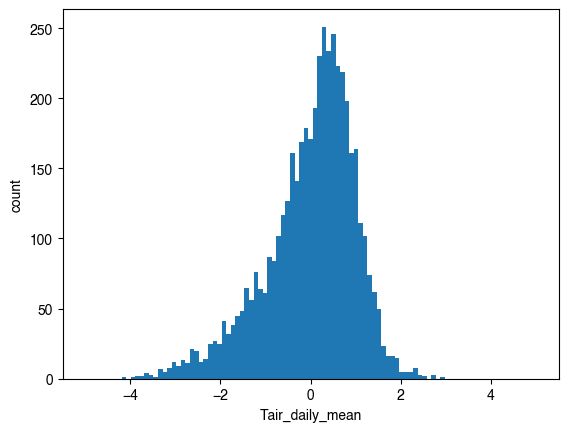

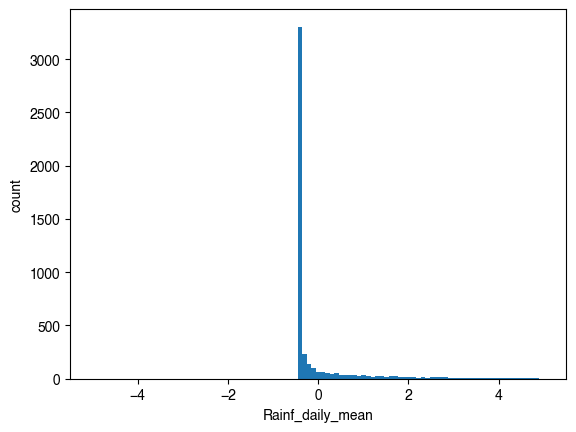

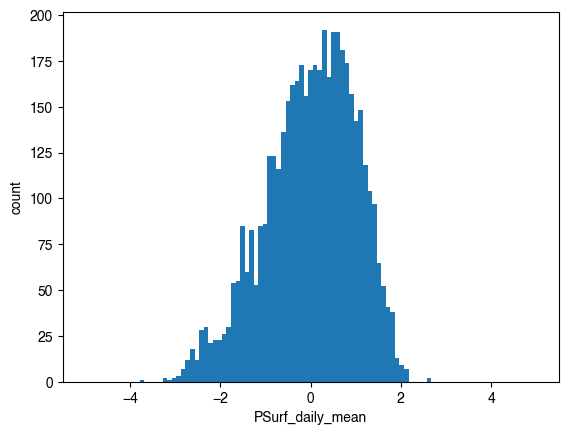

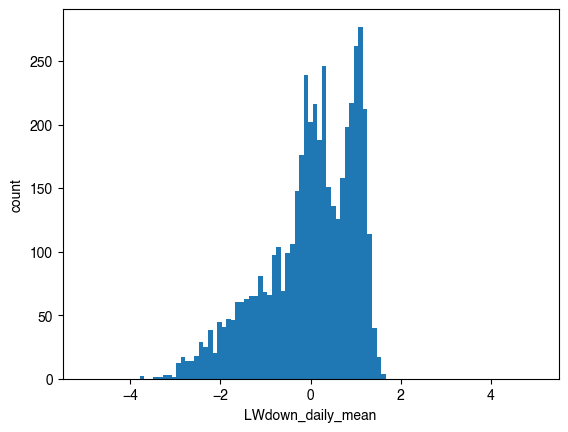

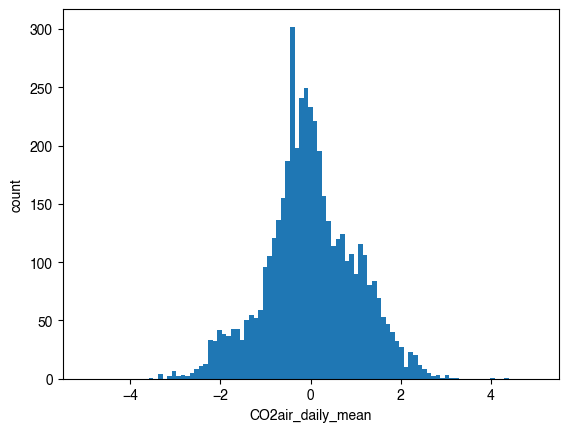

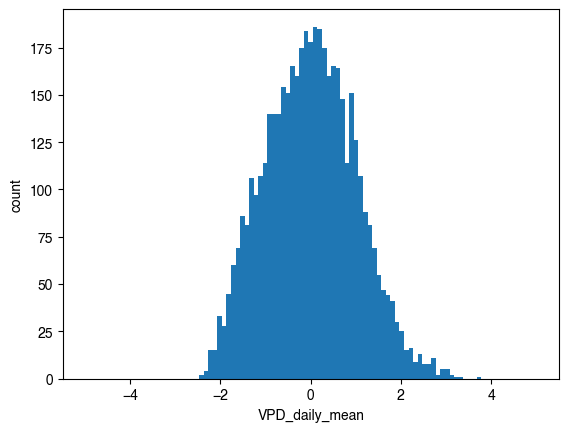

In [13]:
# Get list of coluns
cols = list(ds_daily.keys())[1:]

# histogram bins
bins = np.linspace(-5.,5, 100)

for col in cols:
    plt.hist(ds_daily[col], bins = bins)
    plt.ylabel("count")
    plt.xlabel(col)
    plt.show()

Is this the best normalisation approach for all the values above?

## Model selection

There exist a myriad of different ML models designed for a range of tasks. As with the coice of normalisation tecknique there is no "correct" ML model for any given task, it is also not always clear how any one model will perform compared to another without testing.

The quickest way to reduce the number of models to choose from is to identify the type of task you are trying to solve. In the case of this notebooks task, predicting GPP given some measured environmental properties, we have a regression task. This means we can rule out ML models designed for clasification and generative tasks among others.

Next we identify the type of training that can be conducted using the available data. Here each day has a set of measured properties and an assosiated GPP, allowing for a suppervised training approach. suppervised training meaning that during the training process the model is explicitly told the output that goes with a given input. Given this we can rule out unsupervised, semi-supervised and re-enforcement learning among others.

Finaly we need to consider the form of the data that is input to the model. The different daily measured properties can be presented to the model as a vector of indipendent input values, so we can use a model that takes a vector as input. Fore th sake of simplisity we will ignore the timeseries nature of the data, treating each day as wholy indipendent of one another.

This leaves us with a number of models we could use including, a nerual network, k-nearest neigbours and random forests. Within this work we will make use of a random forest.

The code below creates a random forest model using the SKLearn python package.

In [14]:
RF_model = RandomForestRegressor(n_estimators = 100, max_depth = None)

## The train, validate and test data split

For supervised learning it is necessary to split the data set into three entierly seperate components.

- Training set: The set of labled data on which the model is trained.
- Validation set: The set of data used to identify the optimal model structure (e.g. the number of decision trees in a random forist) and training stratergy (e.g. the size of the training dataset). 
- Test set: The set of data used to asses the model output. This data is not presented to the model during training.

The data is split this way to avoid testing the model using data that it has already seen during the training and model selection process.

The code below splits off the end of the flux data to reat the test data set.

In [15]:
# Get a list f the columns excluding GPP
cols = list(ds_daily.keys())[1:]

# Create numpy array of test data
test_input = ds_daily[cols].sel(time=ds_daily['time.year'] > 2010)
test_input = test_input.to_pandas().to_numpy()

# Ctreate numpy array of GPP for the test data
test_GPP = ds_daily['GPP'].sel(time=ds_daily['time.year'] > 2010)
test_GPP = test_GPP.to_pandas().to_numpy()

print("-- Test data --")
print("input: ", test_input.shape)
print("GPP: ", test_GPP.shape)

-- Test data --
input:  (1446, 6)
GPP:  (1446,)


The code bellow randomly splits the remaining data (before or during 2010) into the training and validation data set.

In [16]:
# Get a list f the columns excluding GPP
cols = list(ds_daily.keys())[1:]

# Create numpy array of test data
tmp_input = ds_daily[cols].sel(time=ds_daily['time.year'] <= 2010)
tmp_input = tmp_input.to_pandas().to_numpy()

# Ctreate numpy array of GPP for the test data
tmp_GPP = ds_daily['GPP'].sel(time=ds_daily['time.year'] <= 2010)
tmp_GPP= tmp_GPP.to_pandas().to_numpy()

validation_input, training_input, validation_GPP , training_GPP= train_test_split(tmp_input, tmp_GPP, test_size = 0.8 )

print("-- Training data --")
print("input: ", training_input.shape)
print("GPP: ", training_GPP.shape)

print("-- Validation data --")
print("input: ", validation_input.shape)
print("GPP: ", validation_GPP.shape)

-- Training data --
input:  (2609, 6)
GPP:  (2609,)
-- Validation data --
input:  (652, 6)
GPP:  (652,)


## Model training

The code bellow is used to train the random forest model. This can take time depending on the model meaning it can be beneficial to keep it seperate from other code.

In [17]:
RF_model.fit(training_input, training_GPP)

RandomForestRegressor()

Next we predict the dailly GPP for both the training and validation data.

In [18]:
training_predictions = RF_model.predict(training_input)
validation_predictions = RF_model.predict(validation_input)

## Model validation

The next step is to validate the accuracy of the models prediction on both the test and validation data set. Note the test data should be left untill after the model has been optimised. The choice of test metric again depends on the problem. Here we are using ML to solve regression so we can make use of test metrics designed for regression.

The code bellow calculates the root mean square error on the predicted GPP for both the test and validation data.

In [19]:
# Calculate the root mean squared error
RMS_error_training   = root_mean_squared_error(training_GPP,   training_predictions)
RMS_error_validation = root_mean_squared_error(validation_GPP, validation_predictions)

print("-- root mean square error --")
print("training:   ", RMS_error_training, "g/m^2/day")
print("validation: ", RMS_error_validation, "g/m^2/day")

-- root mean square error --
training:    1.735763946822941 g/m^2/day
validation:  4.723016085861506 g/m^2/day


Note there is a clear difference between the RMS scores for the training and validation data sets. The model performs significantly better on the training data than the validation data. This is to be expected as the model was trainined on the training data, it was explicitly told what the GPP should be for this data set. For the validation data on the other hand it has never been presentd this data and so can be expected to be less acurate in its prediction.

Using test metrics, such as RMS, gives a general idea of model performance, but does not provide more localised information. The code below directly compare the true GPP and that predicted by the model along with plotting the residuals.

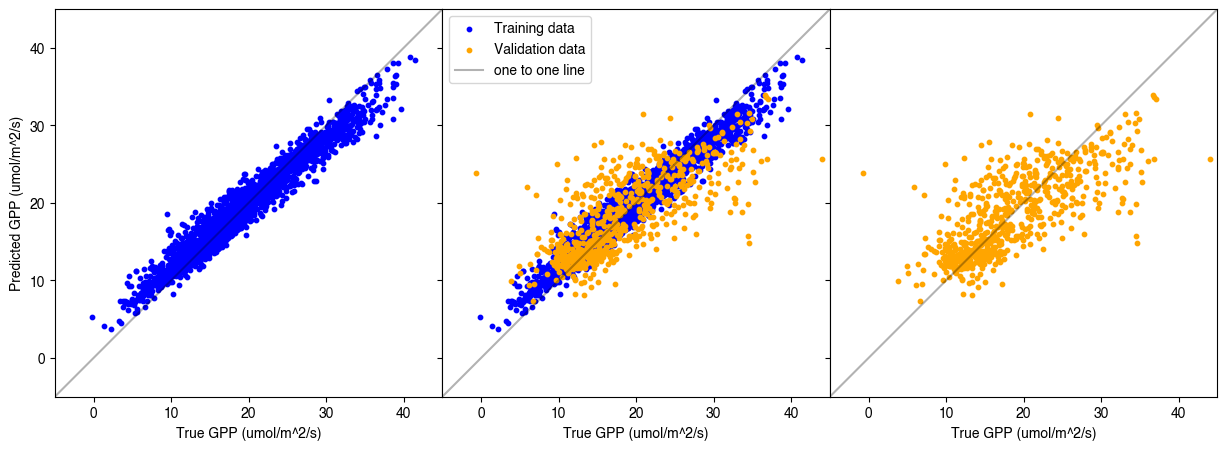

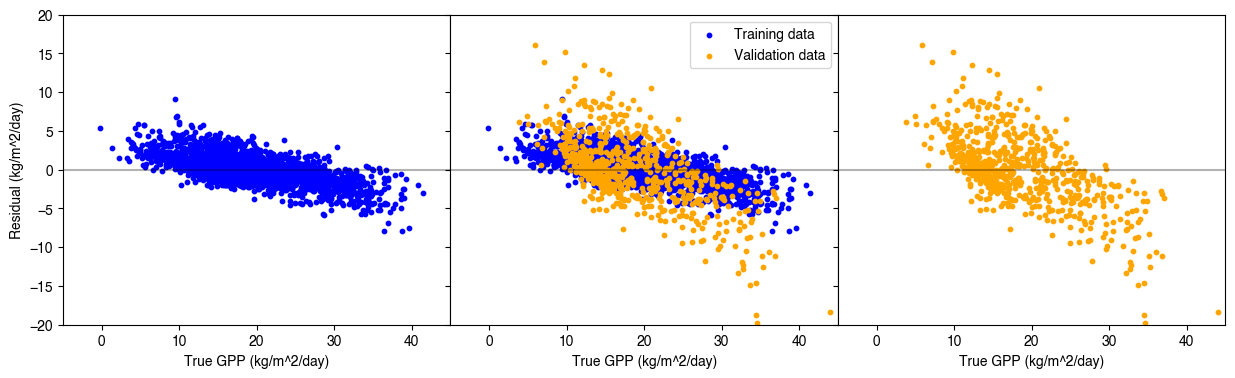

In [20]:
# Plot comparison of prediction to true GPP
fig, axs = plt.subplots(ncols = 3, sharex = True, sharey = True, figsize=(15, 15))
plt.subplots_adjust(wspace=0)

axs[0].scatter(training_GPP,   training_predictions,   s = 10, c = 'blue',   label = 'Training data')
axs[1].scatter(training_GPP,   training_predictions,   s = 10, c = 'blue',   label = 'Training data')
axs[1].scatter(validation_GPP, validation_predictions, s = 10, c = 'orange', label = 'Validation data')
axs[2].scatter(validation_GPP, validation_predictions, s = 10, c = 'orange', label = 'Validation data')

# Add one to one line
for i in range(len(axs)):
    axs[i].plot([-50,50],[-50,50], c = 'black', alpha = 0.3, label = 'one to one line')

# Format plot

for i in range(len(axs)):
    axs[i].set_aspect('equal')
    axs[i].set_xlabel("True GPP (umol/m^2/s)")
    
axs[1].legend()
plt.xlim(-5,45)
plt.ylim(-5,45)
axs[0].set_ylabel("Predicted GPP (umol/m^2/s)")
plt.show()


# Plot residuals of predicted to true GPP
fig, axs = plt.subplots(ncols = 3, sharex = True, sharey = True, figsize=(15, 15))
plt.subplots_adjust(wspace=0)

axs[0].scatter(training_GPP, training_predictions     - training_GPP,   s = 10, c = 'blue',   label = 'Training data')
axs[1].scatter(training_GPP, training_predictions     - training_GPP,   s = 10, c = 'blue',   label = 'Training data')
axs[1].scatter(validation_GPP, validation_predictions - validation_GPP, s = 10, c = 'orange', label = 'Validation data')
axs[2].scatter(validation_GPP, validation_predictions - validation_GPP, s = 10, c = 'orange', label = 'Validation data')
# Add one to one line
for i in range(len(axs)):
    axs[i].plot([-50,50],[0,0], c = 'black', alpha = 0.3)

# Format plot

for i in range(len(axs)):
    axs[i].set_aspect('equal')
    axs[i].set_xlabel("True GPP (kg/m^2/day)")
    
axs[1].legend()
plt.xlim(-5,45)
plt.ylim(-20,20)
axs[0].set_ylabel("Residual (kg/m^2/day)")
plt.show()

These plots clearly show what the two RMS errors told us, the model is better able to predict the training data than the validation. The residual plots also show that the model over predicts (posative residual value) for small values of GPP. The opposit occurs at higher GPP values with the model under predicting (negative residual) the GPP. This tendency for the model to be less acurate at extream values is common to ML and occurs due to reduced training data at extream values.

## Optimising hyper parameters

With any ML model there exist variables that are chosen prior to the training process, e.g. the number of trees in the random forest or the maount of the training data, these are commonly referd to as hyper parameters. Such values can be optimised by looking at how changing them affects the accuracy of the models prediction on the validation data.

The code bellow trains multiple random forests with different numbers of trees, and calculates the RMS error on both the training and validation data for each forest.

In [21]:
# Different numbers of trees to test
tree_count = [1,2,5,10,20,50,100,200,500,1000]

# Arrays to hold the RMS for each model
RMS_error_training_array = np.zeros(len(tree_count))
RMS_error_validation_array = np.zeros(len(tree_count))

# Array to hold training and prediction times
training_time_array = np.zeros(len(tree_count))
prediction_time_array = np.zeros(len(tree_count))

for i in range(len(tree_count)):
    print("Tree count: ", tree_count[i])
    # create model
    current_RF_model = RandomForestRegressor(n_estimators = tree_count[i])

    # Get the time the model training starts
    start_time = time.time()

    # train model
    current_RF_model.fit(training_input, training_GPP)

    # Get the time the model training ends
    end_time = time.time()

    # Calculate the time taken to train the model
    training_time_array[i] = end_time - start_time

    # Get the time the prediction starts
    start_time = time.time()
    
    # test model
    current_training_prediction = current_RF_model.predict(training_input)
    current_validation_prediction = current_RF_model.predict(validation_input)

    # Get the time the prediction ends
    end_time = time.time()

    # Calculate the time taken to predict the GPP
    prediction_time_array[i] = end_time - start_time

    # calculate RMS error
    RMS_error_training_array[i] = root_mean_squared_error(training_GPP, current_training_prediction)
    RMS_error_validation_array[i] = root_mean_squared_error(validation_GPP, current_validation_prediction)    

Tree count:  1
Tree count:  2
Tree count:  5
Tree count:  10
Tree count:  20
Tree count:  50
Tree count:  100
Tree count:  200
Tree count:  500
Tree count:  1000


To asses how changing the number of trees in the random forest affects its accuracy the code bellow plots RMS for both the training and validation data as a function of tree count.

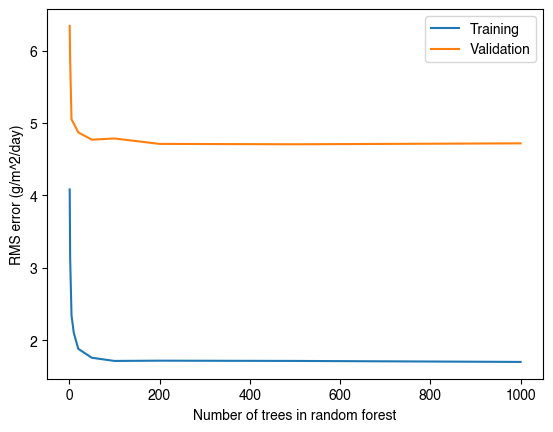

In [22]:
# Plot RSM as a function of number of trees
plt.plot(tree_count, RMS_error_training_array, label = "Training")
plt.plot(tree_count, RMS_error_validation_array, label = "Validation")

# Format plot
plt.ylabel("RMS error (g/m^2/day)")
plt.xlabel("Number of trees in random forest")
plt.legend()
plt.show()

From the plot of RMS against the number of trees in the random forest it is clear that, at low tree counts, the RMS score can be imporved (reduced) by adding more decision trees. As the number of trees increases however the imporvment (reduction) in RMS from adding more tends to zero, implying that there is no benefit to adding more decision trees to the random forest. This trend is pressent for both the training and validation data set.

It is worth noting that if the RMS score began to get worse (increase) for the validation data set but not the training set, it would mean that the model has begun over fitting to the training data.

In general the optimal model is that with the best (lowest) RMS (or other performance metric) for the validation data set, however in some situations the time it takes to train the model or make a prediction is important. The code bellow plots the time taken to train the model as a function of the number of decision trees in the random forest.

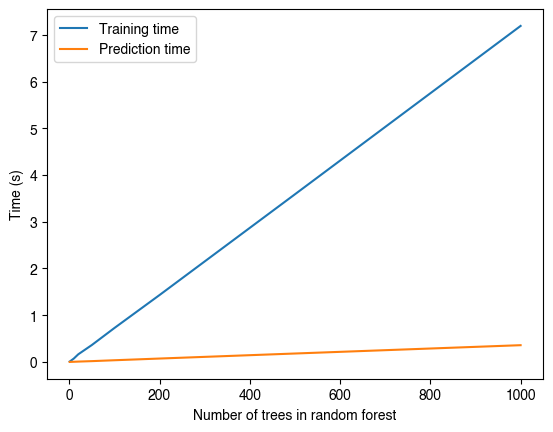

In [23]:
# Plot training time as a function of number of trees
plt.plot(tree_count, training_time_array, label = "Training time")
plt.plot(tree_count, prediction_time_array, label = "Prediction time")

# Format plot
plt.ylabel("Time (s)")
plt.xlabel("Number of trees in random forest")
plt.legend()
plt.show()

There are a number of other hyper parameters that could be optimised to improve the model. What are these hyper parameters and what are their optimal values?

## The final model

Given the results of hyper parameter optimiation above lets use a random forest with 100 decision trees. This achives close to the best RMS score on the validation data without comprimising on the training and prediction times.

The code below creates and rtains the final model.

In [24]:
RF_model =  RandomForestRegressor(n_estimators = 100, max_depth = None)

RF_model.fit(training_input, training_GPP)

RandomForestRegressor()

## Testing the final model

To test the final model we need to first predict the GPP for the test data (remember the test data has not been used for training the model or optimising the hyper parameters).

In [25]:
training_predictions   = RF_model.predict(training_input)
validation_predictions = RF_model.predict(validation_input)
test_predictions       = RF_model.predict(test_input)

As previously we make use of the RMS error as a general assesment of the models predictions

In [26]:
RMS_error_training   = root_mean_squared_error(training_GPP,   training_predictions)
RMS_error_validation = root_mean_squared_error(validation_GPP, validation_predictions)
RMS_error_test       = root_mean_squared_error(test_GPP,       test_predictions)

print("-- root mean square error --")
print("training:   ", RMS_error_training,   "g/m^2/day")
print("validation: ", RMS_error_validation, "g/m^2/day")
print("test:       ", RMS_error_test,       "g/m^2/day")

-- root mean square error --
training:    1.7480615240178807 g/m^2/day
validation:  4.714517231129696 g/m^2/day
test:        7.057485934008768 g/m^2/day


Comparing the RMS error for each data set it is clear that the model performes best on the training data. Of more interest is the difference in RMS error between the validation and training data. The lower RMS error for the validation data set compared to the test set can generaly be atributed to the process of optimising the models hyper parameters. Remember that the hyper parameter optimisation process involves minimising the RMS for the validation data set.

As disscussed previously summary statistics give an assesment of the model performance as a whole, to understand more complex trends it is necessary to plot and inspect the data.

The code below compares the predicted GPP to the true GPP for the different data sets.

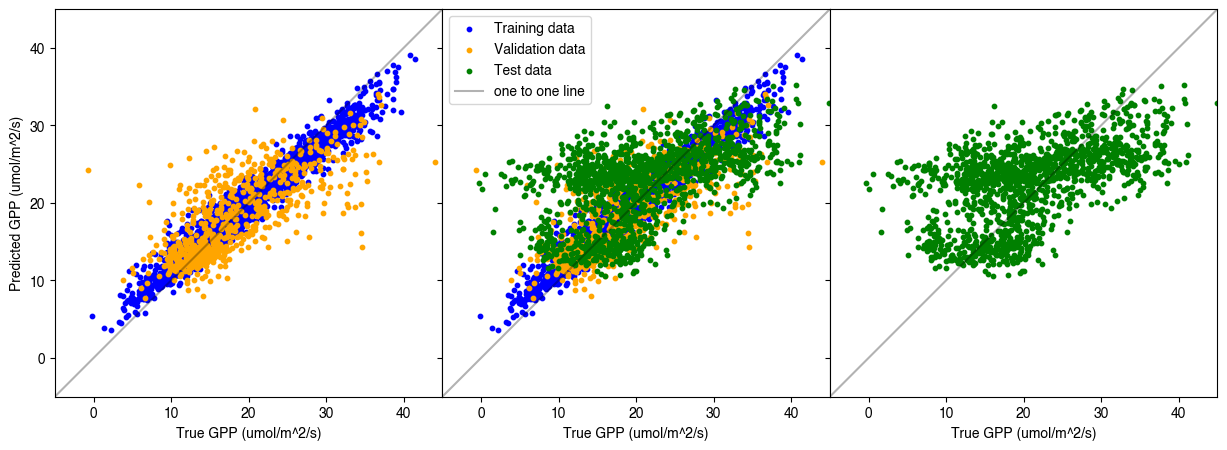

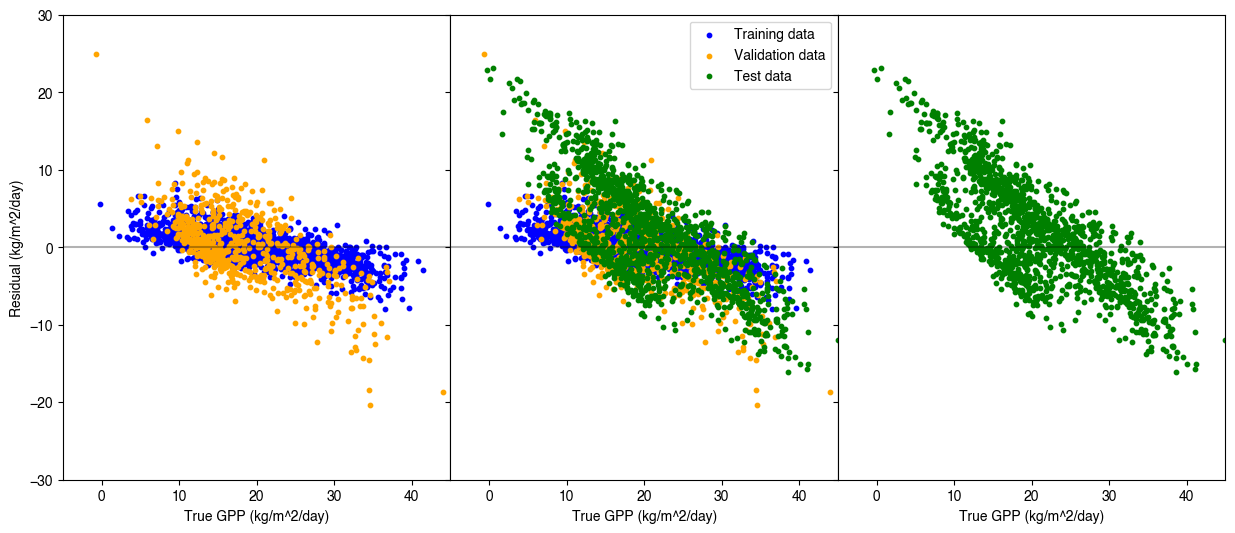

In [27]:
# Plot comparison of prediction to true GPP
fig, axs = plt.subplots(ncols = 3, sharex = True, sharey = True, figsize=(15, 15))
plt.subplots_adjust(wspace=0)

axs[0].scatter(training_GPP,   training_predictions,   s = 10, c = 'blue',   label = 'Training data')
axs[1].scatter(training_GPP,   training_predictions,   s = 10, c = 'blue',   label = 'Training data')
axs[0].scatter(validation_GPP, validation_predictions, s = 10, c = 'orange', label = 'Validation data')
axs[1].scatter(validation_GPP, validation_predictions, s = 10, c = 'orange', label = 'Validation data')
axs[1].scatter(test_GPP,       test_predictions,       s = 10, c = 'green',  label = 'Test data')
axs[2].scatter(test_GPP,       test_predictions,       s = 10, c = 'green',  label = 'Test data')

# Add one to one line
for i in range(len(axs)):
    axs[i].plot([-50,50],[-50,50], c = 'black', alpha = 0.3, label = 'one to one line')

# Format plot

for i in range(len(axs)):
    axs[i].set_aspect('equal')
    axs[i].set_xlabel("True GPP (umol/m^2/s)")
    
axs[1].legend()
plt.xlim(-5,45)
plt.ylim(-5,45)
axs[0].set_ylabel("Predicted GPP (umol/m^2/s)")
plt.show()


# Plot residuals of predicted to true GPP
fig, axs = plt.subplots(ncols = 3, sharex = True, sharey = True, figsize=(15, 15))
plt.subplots_adjust(wspace=0)

axs[0].scatter(training_GPP, training_predictions     - training_GPP,   s = 10, c = 'blue',   label = 'Training data')
axs[1].scatter(training_GPP, training_predictions     - training_GPP,   s = 10, c = 'blue',   label = 'Training data')
axs[0].scatter(validation_GPP, validation_predictions - validation_GPP, s = 10, c = 'orange', label = 'Validation data')
axs[1].scatter(validation_GPP, validation_predictions - validation_GPP, s = 10, c = 'orange', label = 'Validation data')
axs[1].scatter(test_GPP,     test_predictions         - test_GPP,       s = 10, c = 'green',  label = 'Test data')
axs[2].scatter(test_GPP,     test_predictions         - test_GPP,       s = 10, c = 'green',  label = 'Test data')

# Add one to one line
for i in range(len(axs)):
    axs[i].plot([-50,50],[0,0], c = 'black', alpha = 0.3)

# Format plot

for i in range(len(axs)):
    axs[i].set_aspect('equal')
    axs[i].set_xlabel("True GPP (kg/m^2/day)")
    
axs[1].legend()
plt.xlim(-5,45)
plt.ylim(-30,30)
axs[0].set_ylabel("Residual (kg/m^2/day)")
plt.show()

The same over prediction (under prediction) of GPP at low (high) values of GPP is seen here as was previousl. When comparing the results for the validation and test data sets it is difficult to identify if there is a difference (beond the larger size of the test data set).

The analysis of the models predictive ability conducted here is incompleat, what other ways could we test the model? How does the accuracy of the models predictions depend on the input variables? Is there a way to identify which of the inputs are important to the models prediction (feature importance)?